#### read the output file


- Load all the needed packages

In [2]:
import os
import pandas as pd
import matplotlib
import main_single
from os.path import exists
import argparse
import matplotlib.pyplot as plt

import os, fnmatch

In [3]:
model_names = [ 'VRNN-Gauss', 'VRNN-Gauss-I', 'VRNN-GMM', 'VRNN-GMM-I', 'STORN']

In [4]:
# set the path
project_path = "./"
log_path = "log/single_phy_cov/toy_lgssm/"
# log_path = "multi_correct_para/toy_lgssm"
test_output_path = "/data/"

In [5]:
model_name = "VAE-RNN_None"

In [6]:
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                print(root,name)
                result.append(os.path.join(root, name))
    return result



### compare z_estimate and the z_KF 
(the model is VAE-RNN) 

In [7]:
# set the path
project_path = "./"
log_path = "log/single_phy_cov/toy_lgssm/"
# log_path = "multi_correct_para/toy_lgssm"
test_output_path = "/data/"
model_name = "VAE-RNN_None"

In [8]:

# model_name = model_names[1]
pattern = '*.csv'
path = project_path+log_path+model_name

a = find(pattern,path)

./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h42_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h11_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h52_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h57_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h31_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h14_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h36_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h45_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h43_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h40_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h18_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h59_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h4_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_lgssm_h19_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None toy_l

## get the RMSE

In [9]:
import numpy as np
# measurment update of KF
def KF_MU(C, R, y, P, xhat):
    # Kalman filter coefficient
    S = C.dot(P).dot(np.transpose(C)) + R
    K = P.dot(np.transpose(C)) * np.linalg.inv(S)

    # estimated observations
    yhat_ = C.dot(xhat)

    # measurement residual error (innovation error)
    innov = y - yhat_

    # updated estimate of the current state
    xhat = xhat + K.dot(innov)

    # updated state covariane matrix
    P = P - K.dot(C).dot(P)
    
    # TODO: check why the residual is calculated like this
    
    # updated (filtered) output estimate y(k|k)
    yhat = C.dot(xhat)

    return yhat, xhat, P, K


# time update of KF
def KF_TU(A, B, Q, P, xhat, u):
    # update of current state
    xhat = A.dot(xhat) + B.dot(u)

    # update of covariance
    P = A.dot(P).dot(np.transpose(A)) + Q

    return xhat, P

def run_kalman_filter(A, B, C, Q, R, u, y):
    # get simulation time
    k_max = u.shape[-1]

    # sizes
    # The lines `n_x = A.shape[-1]` and `n_y = C.shape[0]` are used to determine the dimensions of the
    # state vector `x` and the measurement vector `y` respectively.
    n_x = A.shape[-1]
    n_y = C.shape[0]

    # allocation
    xhat_list = np.zeros([k_max,n_x])
    yhat = np.zeros([n_y, k_max])
    xhat = np.zeros([n_x, 1])

    # initialization
    P = np.dot(B, np.transpose(B))

    for k in range(k_max):
        # measurement update
        yhat[:, k], xhat, P, K = KF_MU(C, R, y[k], P, xhat)

        # time update
        xhat, P = KF_TU(A, B, Q, P, xhat, u[k])
        xhat_list[k] = xhat.transpose()

    return yhat,xhat_list

In [10]:
def run_toy_lgssm_sim(u, A, B, C, sigma_state, sigma_out):
    # just a standard linear gaussian state space model. Measurement Noise is considered outside
    # same system as in toy examples of "Learning of state-space models with highly informative observations: a tempered
    # Sequential Monte Carlo solution", chapter 5.1
    # additionally measurement noise considered

    # get length of input
    k_max = u.shape[-1]

    # size of variables
    n_u = 1
    n_y = 1
    n_x = 2

    # allocation
    x = np.zeros([n_x, k_max + 1])
    y = np.zeros([n_y, k_max])

    # run over all time steps
    for k in range(k_max):
        x[:, k + 1] = np.dot(A, x[:, k]) + np.dot(B, u[:, k]).transpose() + sigma_state * np.random.randn(n_x)
        y[:, k] = np.dot(C, x[:, k])

    return y,x

In [11]:
# %% output the x, and y given A.B,C,D
A = np.array([[0.7, 0.8], [0, 0.1]])
B = np.array([[-1], [0.1]])
C = np.array([[1], [0]]).transpose()
Q = np.sqrt(0.25) * np.identity(2)
R = np.sqrt(1) * np.identity(1)
sigma_state = np.sqrt(0.25)
sigma_out = np.sqrt(1)
# y_kalman = run_kalman_filter(A, B, C, Q, R, df['u_test'], y_test_noisy)

In [15]:
# model_name = model_names[1]
pattern = '*.csv'
path = project_path+log_path+model_name+test_output_path

# a = find(pattern,path)

pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/toy_lgssm_h80_z2_n1.csv"

df = pd.read_csv(pattern)
df.head()

u=df['u_test'].to_numpy().transpose()
y_kalman, x_kalman = run_kalman_filter(A, B, C, Q, R, df['u_test'], df['y_true'])
# y_kalman, x_kalman = run_kalman_filter(u, A, B, C, sigma_state, sigma_out)


array([[0., 0.]])

In [16]:
x_kalman.shape
x_kf_0 = x_kalman.transpose()[0]
x_kf_1 = x_kalman.transpose()[1]


In [63]:
def plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, length +1), x_kf_0[0:length], linestyle='dotted',color='orange',label='x_kf_0')
    plt.plot(range(1, length +1), x_kf_1[0:length], linestyle='dotted',color='blue',label='x_kf_1')
    plt.plot(range(1, length +1), x_nn_0[0:length], linestyle='-',color='orange',label='x_nn_0')
    plt.plot(range(1, length +1), x_nn_1[0:length], linestyle='-',color='blue',label='x_nn_1')

    plt.xlabel('k step')
    plt.ylabel('value')
    # plt.title('RMSE--RNN hiden states dimension')
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()
    
def plot_k_nn_x_y(x_kf_0,x_kf_1,x_nn_0,x_nn_1, y,length=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, length +1), x_kf_0[0:length], linestyle='dotted',color='orange',label='x_kf_0')
    plt.plot(range(1, length +1), x_kf_1[0:length], linestyle='dotted',color='blue',label='x_kf_1')
    plt.plot(range(1, length +1), x_nn_0[0:length], linestyle='-',color='orange',label='x_nn_0')
    plt.plot(range(1, length +1), x_nn_1[0:length], linestyle='-',color='blue',label='x_nn_1')
    plt.plot(range(1, length +1), y[0:length], linestyle='-',color='red',label='y')
    

    plt.xlabel('k step')
    plt.ylabel('value')
    # plt.title('RMSE--RNN hiden states dimension')
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

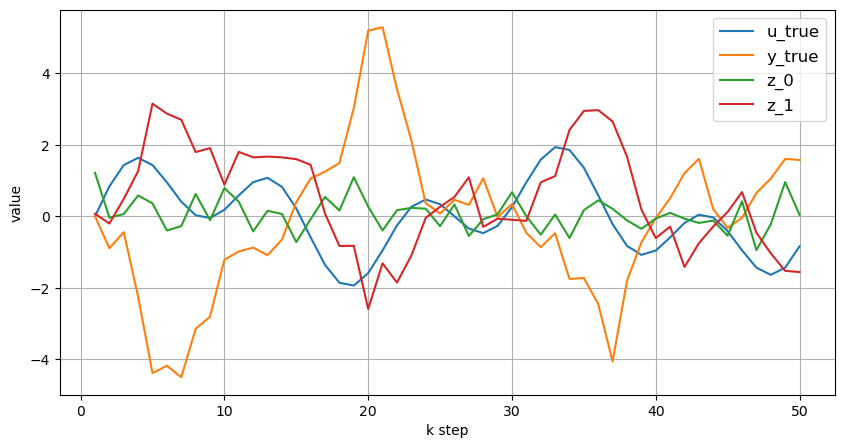

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 50 +1), df['u_test'][0:50], linestyle='-',label='u_true')
plt.plot(range(1, 50 +1), df['y_true'][0:50], linestyle='-',label='y_true')
plt.plot(range(1, 50 +1), df['z_0'][0:50], linestyle='-',label='z_0')
plt.plot(range(1, 50 +1), df['z_1'][0:50], linestyle='-',label='z_1')

plt.xlabel('k step')
plt.ylabel('value')
# plt.title('RMSE--RNN hiden states dimension')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()

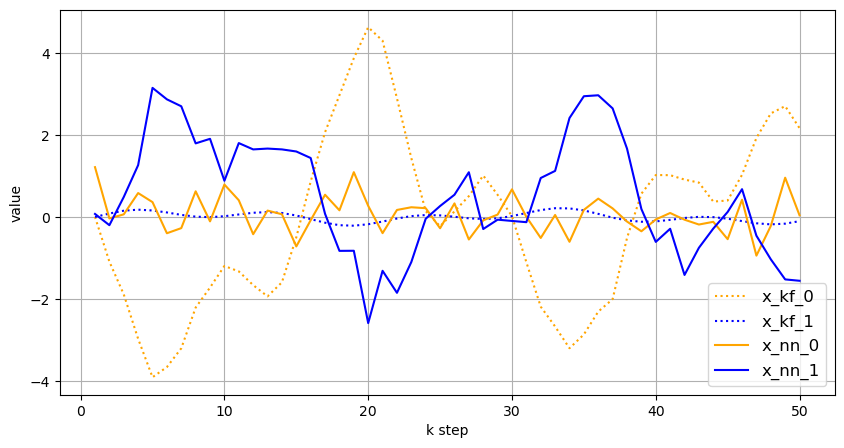

In [23]:
plot_k_nn_x(x_kf_0,x_kf_1,df['z_0'],df['z_1'], length=50)

In [7]:
for root, dirs, files in os.walk(path):
        for name in files:
            print(root,name)

./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h40_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h4_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h58_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h39_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h3_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h42_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h11_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h17_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h52_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h57_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h31_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h80_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h14_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_N

In [8]:
pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h{}_z2_n1.csv"
def read_rsme(pattern, h_dim_max):
    rmse_value = []
    for i in range(1,h_dim_max+1):
        df = pd.read_csv(pattern.format(i))
        rmse_value.append(df["rmse"].mean()) 
    return rmse_value
    

In [9]:
h_dim_max = 80

pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/toy_lgssm_h{}_z2_n1.csv"
rsme_None = read_rsme(pattern, h_dim_max)

pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN-PHY_None/data/toy_lgssm_h{}_z2_n1.csv"
rsme_Measure = read_rsme(pattern, h_dim_max)

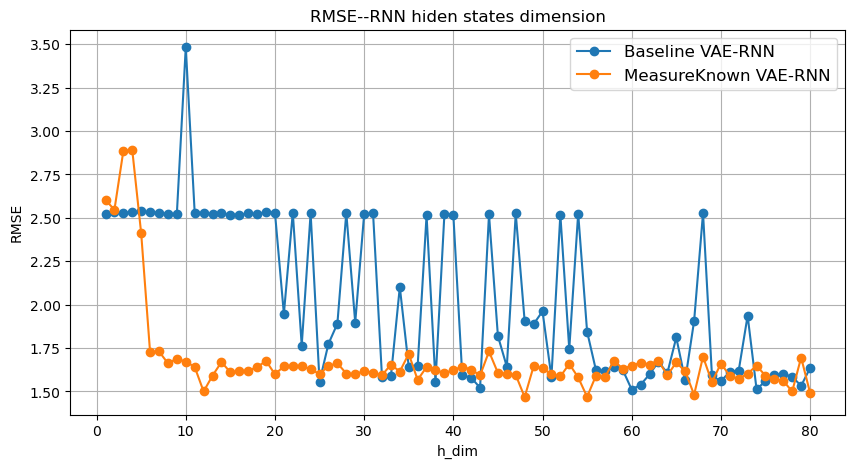

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, h_dim_max +1), rsme_None, marker='o', linestyle='-',label='Baseline VAE-RNN')
plt.plot(range(1, h_dim_max +1), rsme_Measure, marker='o', linestyle='-', label='MeasureKnown VAE-RNN')
plt.xlabel('h_dim')
plt.ylabel('RMSE')
plt.title('RMSE--RNN hiden states dimension')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()

### the mean markdown performance

In [14]:
sum(rsme_None)/len(rsme_None)
rsme_None[79]

1.6340831009034626

In [21]:
sum(rsme_Measure)/len(rsme_Measure)
rsme_Measure[79]
for i in range(0,len(rsme_Measure)):
    if rsme_Measure[i]==min(rsme_Measure):
        print(i)
count = 0
for i in range(0,len(rsme_Measure)):
    if rsme_Measure[i]>rsme_None[i]:
        print(i, rsme_Measure[i],rsme_None[i])
        count+=1
print(count)
min(rsme_Measure)


47
0 2.6026887100258773 2.5190691822620606
1 2.5459626923275436 2.5306289518701712
2 2.8842737115004886 2.5292277099096547
3 2.8897996891246622 2.5307824278633815
24 1.6001586604260862 1.5565424788741884
31 1.5929202739472728 1.5849587499624662
32 1.6549496315621326 1.586115143355722
34 1.7165505550774927 1.642920574292802
37 1.62510796180088 1.556808471397599
40 1.64232367008468 1.5941673692751892
41 1.6261682014567984 1.578644082790879
42 1.591789582739376 1.521622345458307
50 1.5992237914038927 1.5827773272648133
57 1.6770165880533328 1.6411446979304736
58 1.6311027146808734 1.6235092690180992
59 1.648107455274081 1.5111237000396827
60 1.6665026838224564 1.5382986353371009
61 1.6549524052924902 1.5984097239157014
62 1.6765032170325411 1.6703016906044958
65 1.6150500861470847 1.5651309504990825
69 1.6606371002565061 1.5580785382349505
73 1.6480454080929423 1.5133081156043673
74 1.5908376476209536 1.5584488465770998
78 1.6952942630207937 1.5325098343800112
24


1.4674667584475762

### different measurement matrix

In [27]:
import numpy as np
# file_path = 'data/Toy_LGSSM/toy_lgssm_testdata_identical.npz'
file_path = 'data/Toy_LGSSM/toy_lgssm_testdata.npz'

test_data = np.load(file_path)
u=test_data['u_test'].transpose()


In [31]:
test_data['u_test']

array([[ 0.        ],
       [ 0.83647514],
       [ 1.43281019],
       ...,
       [-1.63560362],
       [-1.43281019],
       [-0.83647514]])

#### redefine the state space model

In [46]:
A = np.array([[0.7, 0.8], [0, 0.1]])
B = np.array([[-1], [0.1]])
C = np.array([[1], [-1]]).transpose() # C was redefined
Q = np.sqrt(0.25) * np.identity(2)
R = np.sqrt(1) * np.identity(1)

# y_kalman, x_kalman = run_kalman_filter(A, B, C, Q, R, df['u_test'], df['y_true'])
y_sim, x_sim = run_toy_lgssm_sim(u, A, B, C, sigma_state, sigma_out)
y_sim = y_sim + sigma_out * np.random.randn(1, y_sim.shape[-1])
# save the new dataset
file_new_path = 'data/Toy_LGSSM/toy_lgssm_testdata_identical.npz'
# np.savez(file_new_path, u_test=npz_kw['u_test'], y_test=npz_kw['y_test'],x_sim = x_sim)
npz_kw = np.load(file_new_path)
print(npz_kw.files)

['u_test', 'y_test', 'x_sim']


In [43]:
x_sim

array([[ 0.        , -0.19066938, -1.23858904, ...,  3.05672491,
         3.97687838,  3.57148775],
       [ 0.        , -0.28012864,  0.8090414 , ...,  0.22273795,
         0.23270429, -0.03698765]])

In [61]:
def plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, length +1), x_kf_0[0:length], linestyle='dotted',color='orange',label='x_kf_0')
    plt.plot(range(1, length +1), x_kf_1[0:length], linestyle='dotted',color='blue',label='x_kf_1')
    plt.plot(range(1, length +1), x_nn_0[0:length], linestyle='-',color='orange',label='x_nn_0')
    plt.plot(range(1, length +1), x_nn_1[0:length], linestyle='-',color='blue',label='x_nn_1')

    plt.xlabel('k step')
    plt.ylabel('value')
    # plt.title('RMSE--RNN hiden states dimension')
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

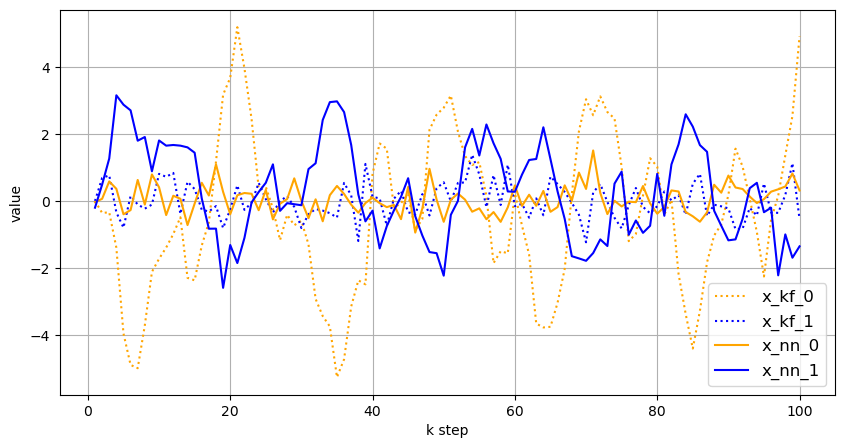

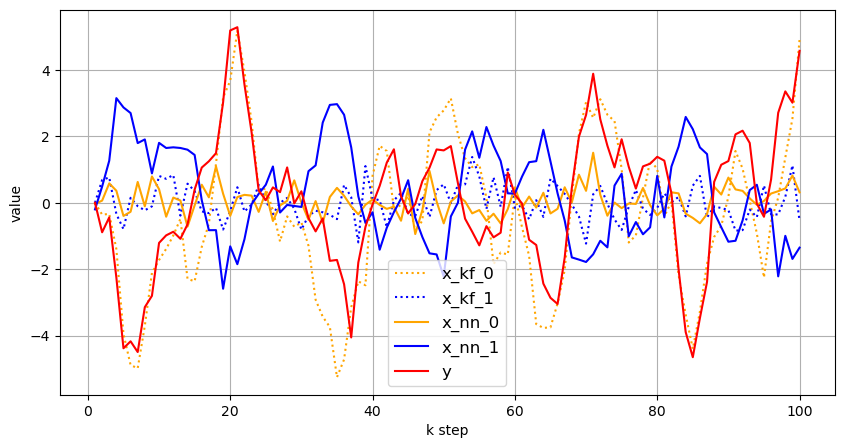

In [80]:

# This is non-physical embedded model
# we found the training data is 

pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/toy_lgssm_h80_z2_n1.csv"

df = pd.read_csv(pattern)
df.head()

A = np.array([[0.7, 0.8], [0, 0.1]])
B = np.array([[-1], [0.1]])
C = np.array([[1], [0]]).transpose()
Q = np.sqrt(0.25) * np.identity(2)
R = np.sqrt(1) * np.identity(1)
sigma_state = np.sqrt(0.25)
sigma_out = np.sqrt(1)


y_sim, x_sim = run_toy_lgssm_sim(u, A, B, C, sigma_state, sigma_out)
# y_kalman, x_kalman = run_kalman_filter(A, B, C, Q, R, u, df["y_true_with_noise"])
x_kf_0 = x_sim[0]
x_kf_1 = x_sim[1]
x_nn_0 = df["z_0"][1:]
x_nn_1 = df["z_1"][1:]
y=df["y_true"]
plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=100)

plot_k_nn_x_y(x_kf_0,x_kf_1,x_nn_0,x_nn_1,y, length=100)

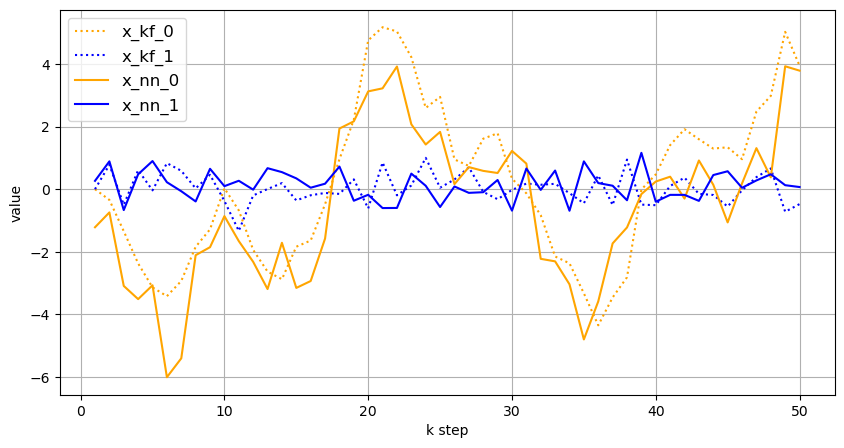

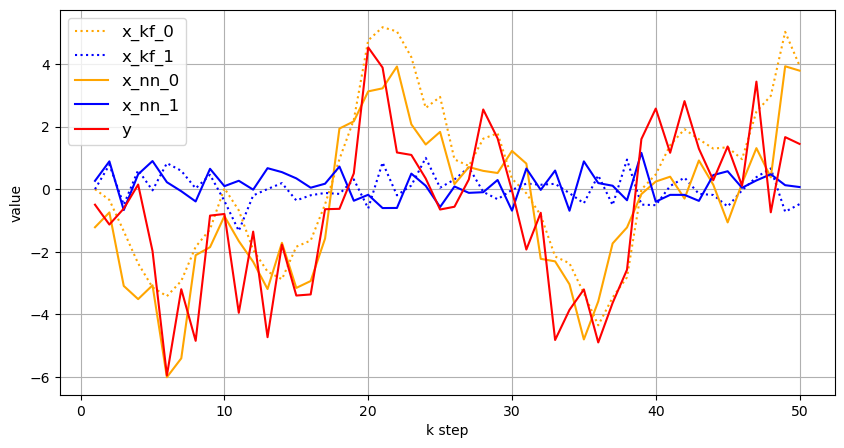

In [65]:
pattern = "./log/single_phy_idmaC/toy_lgssm/VAE-RNN-PHY_None/toy_lgssm_h60_z2_n1.csv"
df = pd.read_csv(pattern)
x_kf_0 = x_sim[0]
x_kf_1 = x_sim[1]
x_nn_0 = df["z_0"]
x_nn_1 = df["z_1"]

plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50)
plot_k_nn_x_y(x_kf_0,x_kf_1,x_nn_0,x_nn_1,y, length=50)


In [39]:
def npz_y_test():
    file_new_path = 'data/Toy_LGSSM/toy_lgssm_testdata.npz'
    np.savez(file_new_path, u_test=test_data['u_test'], y_test=y_sim.transpose())
    npz_kw = np.load(file_new_path)
    print(npz_kw["u_test"])
    print(npz_kw["y_test"])
npz_y_test()

[[ 0.        ]
 [ 0.83647514]
 [ 1.43281019]
 ...
 [-1.63560362]
 [-1.43281019]
 [-0.83647514]]
[[-0.49565518]
 [-1.13046876]
 [-0.61903951]
 ...
 [ 2.31541856]
 [ 1.63262141]
 [ 3.36414932]]


In [41]:
df

,Unnamed: 0,u_test,y_true,y_true_with_noise,y_predict_mu,y_predict_sigma,z_0,z_1
0,0,0.000000,0.000000,-1.473179,0.102809,1.150823,1.215642,0.074015
1,1,0.836475,-0.889567,1.712950,1.027605,1.113881,-0.036228,-0.200555
2,2,1.432810,-0.441679,-2.207763,-0.288578,1.117739,0.063897,0.487584
3,3,1.635604,-2.250232,-2.705119,-1.607768,1.174161,0.583349,1.265068
4,4,1.432113,-4.382381,-3.877919,-4.590371,1.140256,0.362190,3.150032
...,...,...,...,...,...,...,...,...
4995,4995,-0.951057,0.618047,1.256455,0.175375,1.088899,0.013111,0.230954
4996,4996,-1.432113,2.192982,2.116796,1.258709,1.118860,0.235614,-0.322829
4997,4997,-1.635604,2.519956,2.201552,2.264109,1.077903,0.458472,-0.965344
4998,4998,-1.432810,3.634861,4.837926,4.135580,1.172657,-0.354272,-2.336734


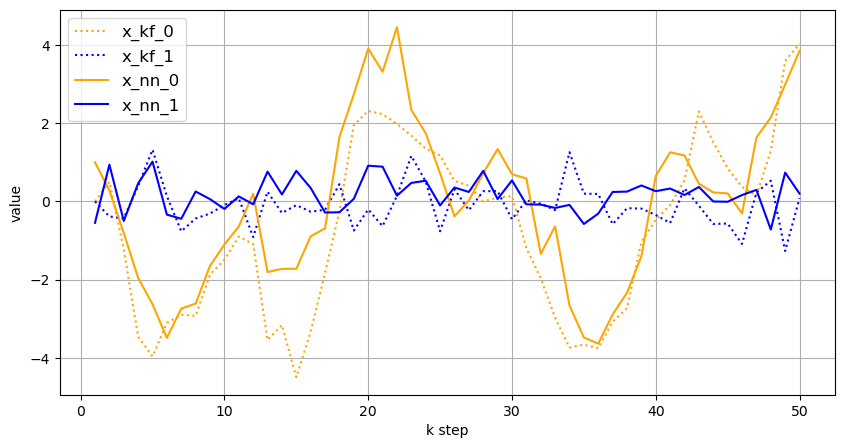

In [20]:

# a = find(pattern,path)

pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN-PHY_None/toy_lgssm_h80_z2_n1.csv"

df = pd.read_csv(pattern)
df.head()

x_kf_0 = x_kalman[0]
x_kf_1 = x_kalman[1]
x_nn_0 = df["z_0"]
x_nn_1 = df["z_1"]

plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50)

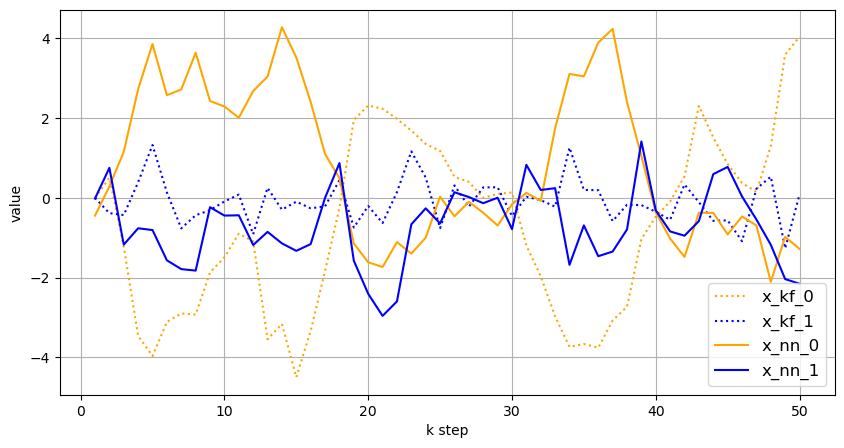

In [21]:

# a = find(pattern,path)

pattern = "./log/single_phy_idmaC/toy_lgssm/VAE-RNN_None/toy_lgssm_h80_z2_n1.csv"

df = pd.read_csv(pattern)
df.head()

x_kf_0 = x_kalman[0]
x_kf_1 = x_kalman[1]
x_nn_0 = df["z_0"]
x_nn_1 = df["z_1"]

plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50)

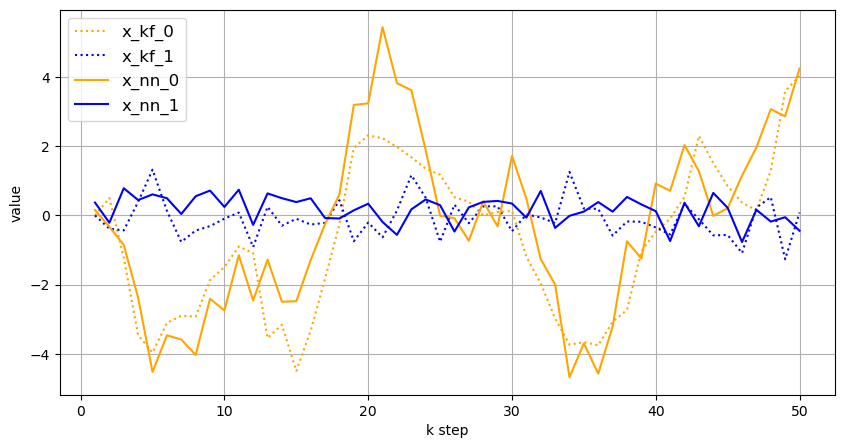

In [23]:

# a = find(pattern,path)

pattern = "./log/single_phy_idmaC/toy_lgssm/VAE-RNN-PHY_None/toy_lgssm_h60_z2_n1.csv"

df = pd.read_csv(pattern)
df.head()

x_kf_0 = x_kalman[0]
x_kf_1 = x_kalman[1]
x_nn_0 = df["z_0"]
x_nn_1 = df["z_1"]

plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50)

### different noises

In [ ]:
A = np.array([[0.7, 0.8], [0, 0.1]])
B = np.array([[-1], [0.1]])
C = np.array([[1], [0]]).transpose()
Q = np.sqrt(0.25) * np.identity(2)
R = np.sqrt(1) * np.identity(1)

### generate the command runing the python script several times

In [60]:
command = ""
for model_name in model_names:
    for known_parameter in ['None', 'B']:
        command += "python main_single.py --model \"{}\" --known_parameter \"{}\"\n".format(model_name, known_parameter)
        
myBat = open(r'sameinput_multi.bat','w+')
myBat.write(command)
myBat.close()


In [ ]:


def read_single_output_RMSE_log(path_general, options):
    path_RMSE_log = path_general+"RSME.csv"
    if exists(path_RMSE_log):
        RMSE_log = pd.read_csv(path_RMSE_log)
    else:                                
        generate_output_RMSE_log(path_general,options)
        
def get_more_test(options, path_general, file_name_general):
    available_RMSE = read_single_output_RMSE_log(path_general)

- read from csv file and plot the result?

In [25]:
# set the path
# project_path = "/log_Server/final/toy_lgssm"
project_path = "log/multi_correct_para/toy_lgssm/"
model_names = ['VAE-RNN', 'VRNN-Gauss', 'VRNN-Gauss-I', 'VRNN-GMM', 'VRNN-GMM-I', 'STORN']
para_type = ['B','None']


# generate the list of trained models
output_files = []
model_names_paras = []
rmse_lgssm = {}
for mn in model_names:
    for pt in para_type:
        model_names_para = mn+'_'+pt
        model_names_paras.append(model_names_para)
        
        data_path = (project_path+mn+'_'+pt+"/")
        all_files = os.listdir(data_path)   
        readable_file = data_path +  list(filter(lambda f: f.endswith('multitrain.csv'), all_files))[0]
        print(readable_file)
        
        df = pd.read_csv(readable_file)
        rmse_lgssm[model_names_para] = df["rmse"].mean()
        
        output_files.append(readable_file)
    

log/multi_correct_para/toy_lgssm/VAE-RNN_B/toy_lgssm_h80_z10_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VAE-RNN_None/toy_lgssm_h80_z10_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-Gauss_B/toy_lgssm_h80_z2_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-Gauss_None/toy_lgssm_h80_z2_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-Gauss-I_B/toy_lgssm_h50_z5_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-Gauss-I_None/toy_lgssm_h50_z5_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-GMM_B/toy_lgssm_h50_z5_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-GMM_None/toy_lgssm_h50_z5_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-GMM-I_B/toy_lgssm_h70_z10_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-GMM-I_None/toy_lgssm_h70_z10_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/STORN_B/toy_lgssm_h60_z5_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/STORN_None/toy_lgssm_h60_z5_n1_multitrain.csv


In [26]:
sorted_rmse_lgssm={k: v for k, v in sorted(rmse_lgssm.items(), key=lambda item: item[1])}

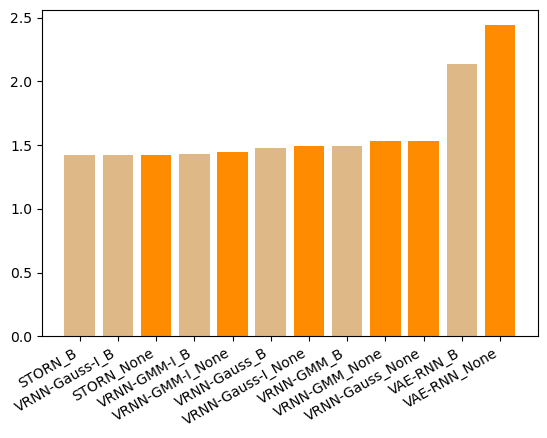

In [27]:

fig, ax = plt.subplots()

colors = []
for m in list(sorted_rmse_lgssm.keys()):
    if m.endswith('B'):
        colors.append("burlywood")
    else:
        colors.append("darkorange")
ax.bar(list(sorted_rmse_lgssm.keys()), list(sorted_rmse_lgssm.values()),color = colors)
fig.autofmt_xdate()
plt.show()

In [28]:
print(list(sorted_rmse_lgssm.values()))

[1.4188597453486662, 1.4224553157094477, 1.4250652253477856, 1.4270555641899896, 1.4442504061640227, 1.476195338737786, 1.4900349437337612, 1.4945988635356704, 1.531030633737399, 1.5314691034502328, 2.1335312130438195, 2.438333051008554]


In [29]:
print(list(sorted_rmse_lgssm.keys()))

['STORN_B', 'VRNN-Gauss-I_B', 'STORN_None', 'VRNN-GMM-I_B', 'VRNN-GMM-I_None', 'VRNN-Gauss_B', 'VRNN-Gauss-I_None', 'VRNN-GMM_B', 'VRNN-GMM_None', 'VRNN-Gauss_None', 'VAE-RNN_B', 'VAE-RNN_None']
